In [17]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_commits = list(Path("../../logs/performance/git_heads").glob("*/"))
list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:1]
list_of_files = list(Path(list_of_commits[0] / "all").glob("*.csv"))

# Find the latest file
latest_file = max(list_of_files, key=os.path.getctime)

# Load the latest CSV file into a DataFrame
df_latest = pd.read_csv(latest_file)
# format: timestamp,category,test_name,query,scenario,execution_time,results_consistent,fainder_mode,num_results,ids,num_terms,id_str
print(df_latest)

# First check the unique category values to see what we're working with
print("Unique categories:", df_latest["category"].unique())

# Strip whitespace and normalize the category column
df_latest["category"] = df_latest["category"].str.strip()

               timestamp                          category  \
0    2025-05-19 10:32:48              base_keyword_queries   
1    2025-05-19 10:32:48              base_keyword_queries   
2    2025-05-19 10:32:48              base_keyword_queries   
3    2025-05-19 10:32:48              base_keyword_queries   
4    2025-05-19 10:32:48              base_keyword_queries   
..                   ...                               ...   
495  2025-05-19 12:17:36  multiple_percentile_combinations   
496  2025-05-19 12:17:42  multiple_percentile_combinations   
497  2025-05-19 12:17:42  multiple_percentile_combinations   
498  2025-05-19 12:17:42  multiple_percentile_combinations   
499  2025-05-19 12:17:42  multiple_percentile_combinations   

                                   test_name  \
0                           simple_keyword_1   
1                           simple_keyword_1   
2                           simple_keyword_1   
3                           simple_keyword_1   
4              

In [18]:
# Filter the DataFrame by category with stripped values
base_keyword_queries = df_latest[df_latest["category"] == "base_keyword_queries"]
base_keyword_queries = base_keyword_queries[base_keyword_queries["results_consistent"]]
base_percentile_queries = df_latest[df_latest["category"] == "base_percentile_queries"]
base_percentile_queries = base_percentile_queries[
    base_percentile_queries["results_consistent"]
].reset_index()
percentile_combinations = df_latest[df_latest["category"] == "percentile_combinations"]
percentile_combinations = percentile_combinations[
    percentile_combinations["results_consistent"]
].reset_index()
mixed_combinations_with_fixed_structure = df_latest[
    df_latest["category"] == "mixed_combinations_with_fixed_structure"
]
mixed_combinations_with_fixed_structure = mixed_combinations_with_fixed_structure[
    mixed_combinations_with_fixed_structure["results_consistent"]
].reset_index()
multiple_percentile_combinations = df_latest[
    df_latest["category"] == "multiple_percentile_combinations"
]
multiple_percentile_combinations = multiple_percentile_combinations[
    multiple_percentile_combinations["results_consistent"]
].reset_index()

# Print to verify the filtering worked
print("\nCounts after fixing whitespace:")
print("Base keyword queries:", len(base_keyword_queries))
print("Base percentile queries:", len(base_percentile_queries))
print("Mixed combinations with fixed structure:", len(mixed_combinations_with_fixed_structure))
print("Percentile combinations:", len(percentile_combinations))
print("Multiple percentile combinations:", len(multiple_percentile_combinations))
scenarios = base_keyword_queries["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]


Counts after fixing whitespace:
Base keyword queries: 24
Base percentile queries: 64
Mixed combinations with fixed structure: 80
Percentile combinations: 144
Multiple percentile combinations: 28


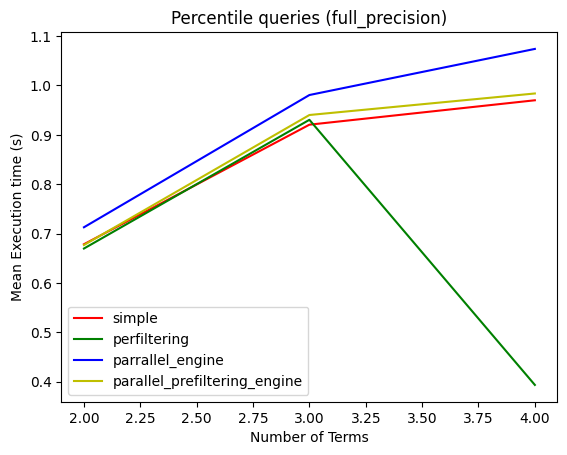

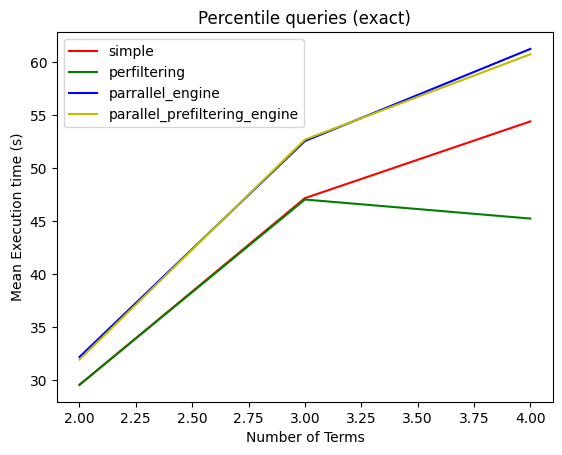

In [19]:
# plot percentile_combinations comparing different scenarios (per fainder mode)

fainder_modes = percentile_combinations["fainder_mode"].unique()
for fainder_mode in fainder_modes:
    plt.figure()
    df_mode = percentile_combinations[percentile_combinations["fainder_mode"] == fainder_mode]
    for i, scenario in enumerate(scenarios):
        df_scenario = df_mode[df_mode["scenario"] == scenario]

        mean_execution_times = df_scenario.groupby("num_terms")["execution_time"].mean()

        plt.plot(
            mean_execution_times.index,
            mean_execution_times.values,
            label=scenario,
            color=colors[i],
        )

    plt.xlabel("Number of Terms")
    plt.ylabel("Mean Execution time (s)")
    plt.title(f"Percentile queries ({fainder_mode})")
    plt.legend()
plt.show()

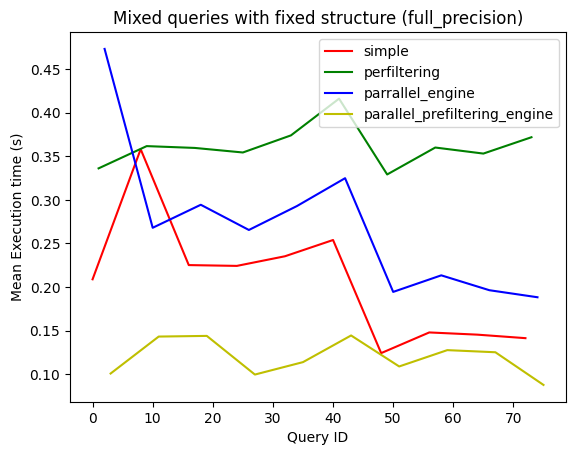

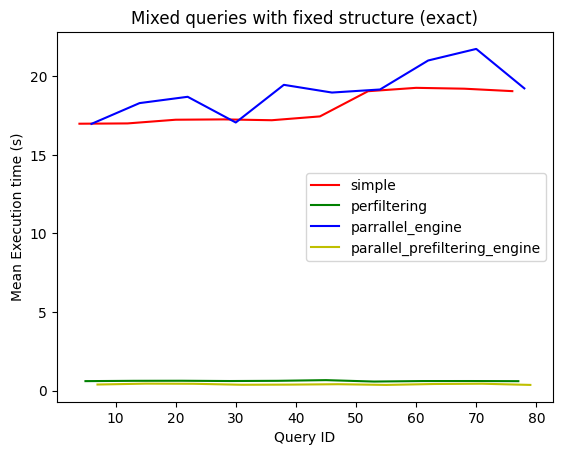

In [20]:
# plot mixed_combinations_with_fixed_structure comparing different scenarios (per fainder mode)
fainder_modes = mixed_combinations_with_fixed_structure["fainder_mode"].unique()
for _, fainder_mode in enumerate(fainder_modes):
    df_mixed = mixed_combinations_with_fixed_structure[
        mixed_combinations_with_fixed_structure["fainder_mode"] == fainder_mode
    ]
    plt.figure()
    for h, scenario in enumerate(scenarios):
        mean_execution_times = df_mixed[df_mixed["scenario"] == scenario]

        plt.plot(
            mean_execution_times.index,
            mean_execution_times["execution_time"],
            label=scenario,
            color=colors[h],
        )
    plt.xlabel("Query ID")
    plt.ylabel("Mean Execution time (s)")
    plt.title("Mixed queries with fixed structure (" + fainder_mode + ")")
    plt.legend()
plt.show()

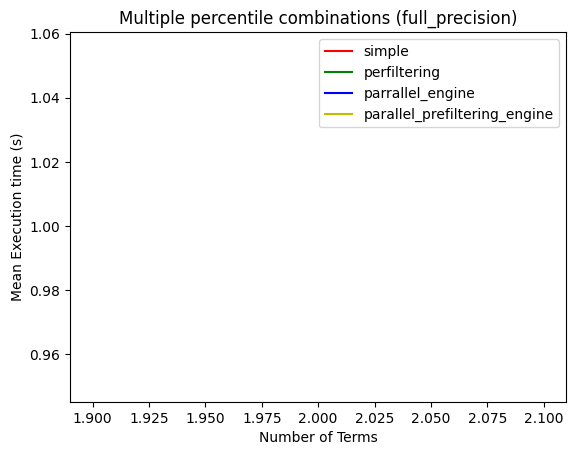

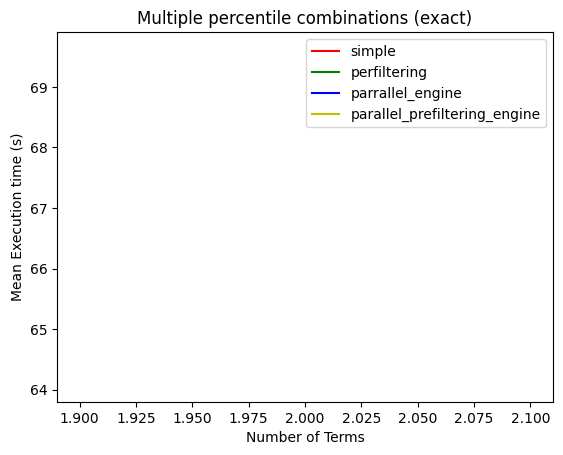

In [21]:
# plot multiple_percentile_combinations comparing different scenarios (per fainder mode)
fainder_modes = multiple_percentile_combinations["fainder_mode"].unique()

for _, fainder_mode in enumerate(fainder_modes):
    df = multiple_percentile_combinations[
        multiple_percentile_combinations["fainder_mode"] == fainder_mode
    ]
    plt.figure()
    for h, scenario in enumerate(scenarios):
        df_multiple = df[df["scenario"] == scenario]

        mean_execution_times = df_multiple.groupby("num_terms")["execution_time"].mean()
        plt.plot(
            mean_execution_times.index,
            mean_execution_times.values,
            label=scenario,
            color=colors[h],
        )
    plt.xlabel("Number of Terms")
    plt.ylabel("Mean Execution time (s)")
    plt.title("Multiple percentile combinations" + " (" + fainder_mode + ")")
    plt.legend()
plt.show()

Text(0.5, 1.0, 'Base Queries Execution Time')

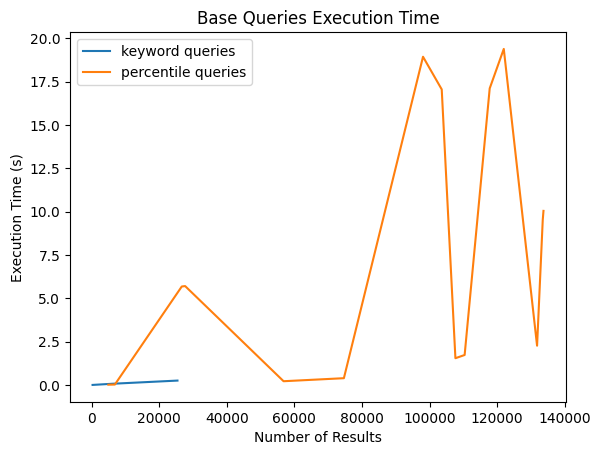

In [22]:
# compare kw vs pp time for base queries (for cost based optimization)

# relevant columns: execution_time number_of_results (seneario is irrelevant for base queries)
plt.figure()

df = base_keyword_queries.groupby("num_results")["execution_time"].mean()

plt.plot(df.index, df, label="keyword queries")

df = base_percentile_queries.groupby("num_results")["execution_time"].mean()

plt.plot(df.index, df, label="percentile queries")

plt.xlabel("Number of Results")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.title("Base Queries Execution Time")

In [23]:
# Compare the execution time (y-axis) per query (x-axis) (one line per scenario)
# new plot per fainder mode per category
fainder_modes = df_latest["fainder_mode"].unique()

for category in df_latest["category"].unique():
    for fainder_mode in fainder_modes:
        plt.figure()
        df = df_latest[df_latest["fainder_mode"] == fainder_mode]
        df = df[df["category"] == category]
        for i, scenario in enumerate(scenarios):
            df_scenario = df[df["scenario"] == scenario]

            df_scenario = df_scenario.reset_index()

            plt.bar(
                df_scenario.index,
                df_scenario["execution_time"],
                label=scenario,
                color=colors[i],
            )

        plt.xlabel("Query ID")
        plt.ylabel("Mean Execution time (s)")
        plt.title(f"{category} ({fainder_mode})")
        plt.legend()
        plt.savefig(f"{category}_{fainder_mode}.png")
        plt.close()


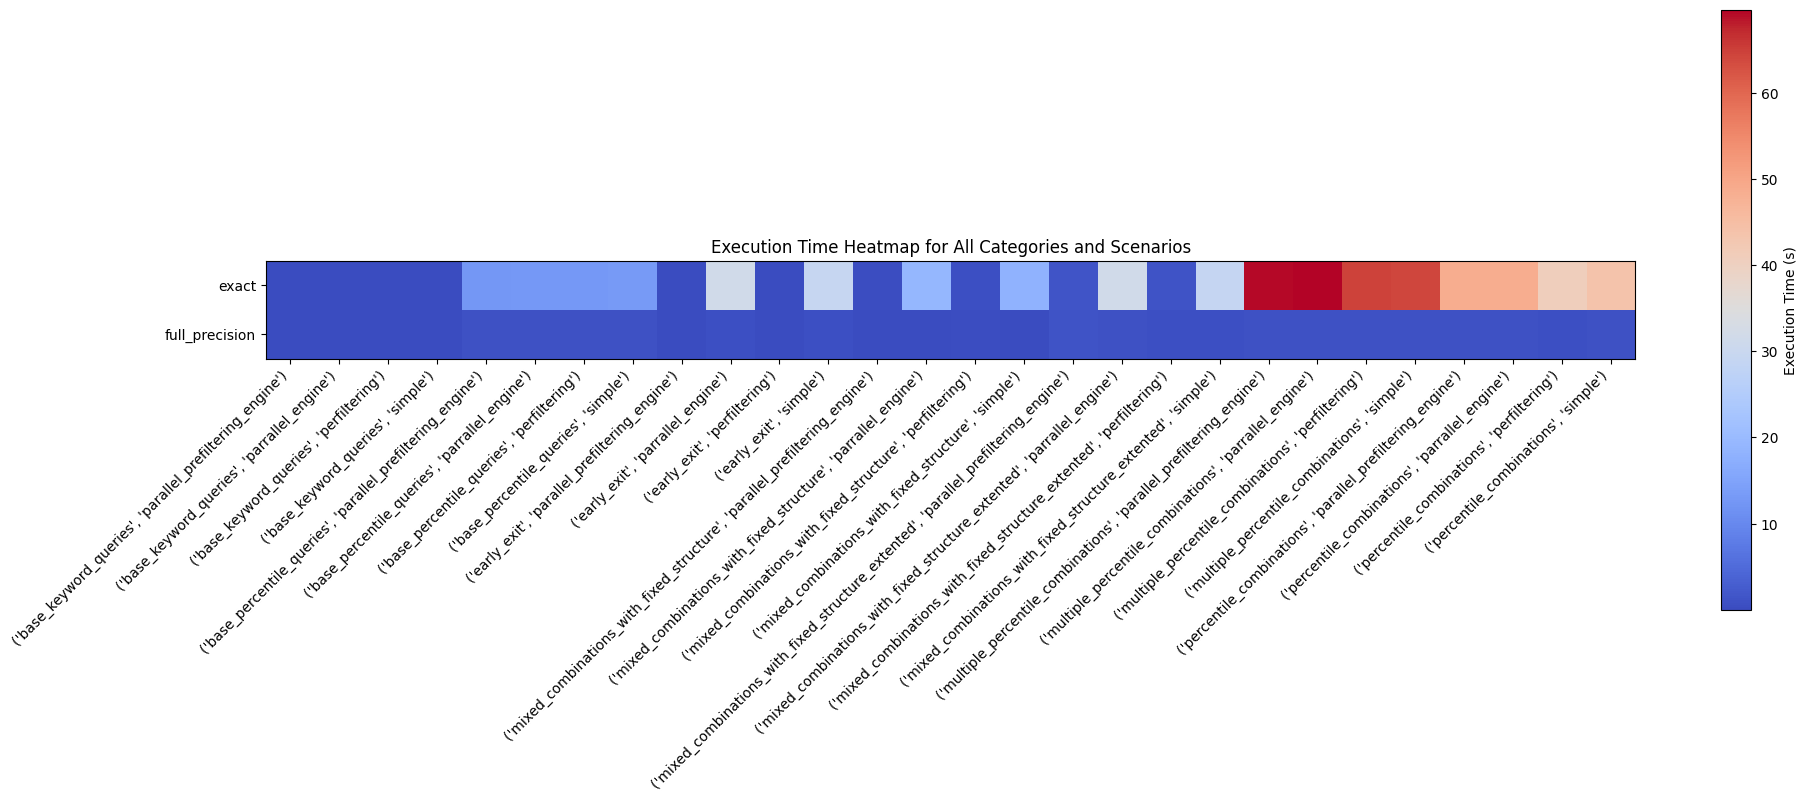

In [24]:
# compact heatmap for all categories and scenarios 
def create_heatmap(df, title):
    pivot_table = df.pivot_table(
        index="fainder_mode", columns=["category", "scenario"], values="execution_time", aggfunc="mean"
    )
    plt.figure(figsize=(20, 8))  # Increased figure width
    plt.imshow(pivot_table, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Execution Time (s)")
    
    # Rotate and align the tick labels so they look better
    plt.xticks(range(len(pivot_table.columns)), pivot_table.columns, rotation=45, ha='right')
    plt.yticks(range(len(pivot_table.index)), pivot_table.index)
    
    # Add some spacing between the plot and the labels
    plt.tight_layout()
    
    plt.title(title)
    plt.show()

# Create heatmap for all categories and scenarios
create_heatmap(df_latest, "Execution Time Heatmap for All Categories and Scenarios")